In [78]:
%pip install scikit-learn scipy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Алгоритмы кластеризации

Задание на сегодня состоит из двух задач. Нужно реализовать алгоритмы k-means и иерархическую кластеризацию.

### 1. K-Means (1 балл)

Реализуйте метод сжатия изображений в формате PNG с помощью кластеризации пикселей. 

Общая схема работы метода:

* С помощью алгоритма Ллойда построить по изображению набор из **K** базовых цветов. Базовый цвет – это центроид в пространстве RGB.

* Преобразовать исходное изображение в новое, в котором каждый пиксель заменен на ближайший к нему базовый цвет.

Необходимо, чтобы преобразованное изображение визуально не сильно отличалось от исходного

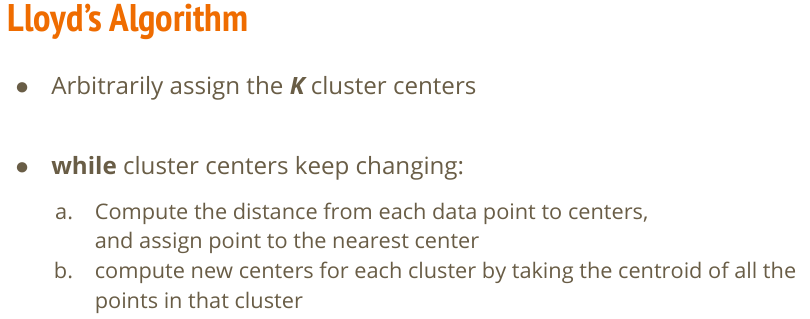

Алгоритм минимизирует функцию ошибки (**loss function**) вида

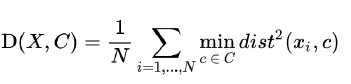

Расстояние между точками евклидово

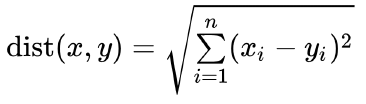

In [79]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial import distance

Для проверки критерия сходимости можно использовать функцию `np.allclose(x, y)`

In [80]:
np.allclose([[1,2,3], [1,2,3]], [[1,2,3], [1,2,2.95]], atol=0.01)

False

In [81]:
np.allclose([[1,2,3], [1,2,3]], [[1,2,3], [1,2,2.95]], atol=0.1)

True

#### Загрузка данных

In [82]:
# Загрузим картинку
img = plt.imread("flower.png")[:,:,:3]

# Теперь в переменной img находится трехмерный массив чисел. 
print(img.shape)

(427, 640, 3)


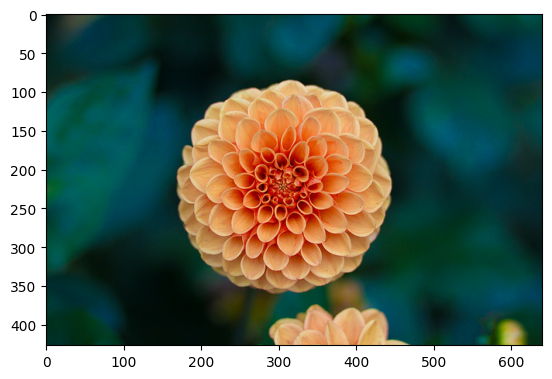

In [83]:
_ = plt.imshow(img)

In [84]:
# Цвет каждой точки задается трехмерным вектором в пространстве RGB. Это наши признаки.
print(img[400, 500])

[0.04313726 0.12156863 0.11372549]


In [85]:
# Преобразуем массив в двумерный. Теперь первая координата – номер точки, вторая – ее признаки 
X = img.reshape((-1,3))
print(X.shape)

(273280, 3)


In [86]:
X[0,2]

0.050980393

In [87]:
X.shape[1]

3

#### Кластеризация

Примерная структура класса. Можно менять, если хотите

In [88]:
class KMeans(object):
    # can't give any warranty that the comments with methods description correspond truth
    # (I just escaped warnings from initial descriptions after I'd implemented methods, but didn't read deeply)
    def __init__(self, k_clusters, max_iter, seed=42, accuracy=1e-3, metric='euclidean'):
        self.k_clusters = k_clusters
        self.max_iter = max_iter
        self.seed = seed
        self.accuracy = accuracy
        self.metric = metric
        self.losses = []
        self.labels = []
        self.exdog = None
        self.centroids = None

    def initialize(self, exdog=None):
        """
        Initialize centroids
        :param exdog: array-like of shape (n_samples, n_features)
            Training instances to cluster

        """
        np.random.seed(self.seed)
        if exdog is not None:
            self.exdog = exdog
        if self.exdog is None and exdog is None:
            raise ValueError('Need to provide exdog data')

        n_samples, _ = self.exdog.shape  # n_samples, _n_features
        return self.exdog[np.random.permutation(n_samples)[:self.k_clusters]]

    def fit_predict(self, exdog=None):
        """
        Implements Lloyd's algorithm
        :param exdog: array-like of shape (n_samples, n_features)
            Training instances to cluster
        :return labels : ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to.
        """
        new_centroids = self.initialize(exdog)
        self.centroids = new_centroids + self.accuracy * 10
        i = 0
        while not np.allclose(new_centroids, self.centroids, atol=self.accuracy) and i < self.max_iter:
            i += 1
            self.centroids = new_centroids
            dist = self.get_distances_to_centroids()
            self.losses.append(self.loss_function(np.min(dist, axis=1)))
            self.labels = np.argmin(dist, axis=1)
            new_centroids = self.find_centroid_for_clusters()

        return self.labels

    def get_distances_to_centroids(self):
        """
        Returns distance from each sample to all centroids
        :return dist: array-like of shape (n_samples, n_clusters)
            Matrix of distances
        """
        return distance.cdist(self.exdog, self.centroids, self.metric)

    def find_centroid_for_clusters(self):
        return np.array([self.centroid_for_cluster(label_j) for label_j in range(self.k_clusters)])

    def centroid_for_cluster(self, label: int) -> np.ndarray:
        return self.exdog[self.labels == label].mean(axis=0)

    @staticmethod
    def loss_function(dist) -> float:
        """
        :param dist: array-like of shape (n_samples, n_clusters)
            Matrix of distances
        :return loss: float
            Value of the loss function
        """
        return np.sum(dist ** 2) / len(dist)

In [89]:
import time
import tracemalloc

def replace_points_with_centroids(centroids_, labels):
    return centroids_[labels, :] 

def interact_k_means(k: int, max_iter: int = 100, accuracy: float = 1e-3, seed: int = 42):
    kmeans = KMeans(k_clusters=k, max_iter=max_iter, seed=seed, accuracy=accuracy)
    tracemalloc.start()
    tracemalloc.clear_traces()
    start = time.time_ns()
    y_pred = kmeans.fit_predict(X)
    exec_time = time.time_ns() - start
    memory_usage_kb  = tracemalloc.get_traced_memory()[1] / 1024
    tracemalloc.clear_traces()
    tracemalloc.stop() 
    
    print(f'execution time(sec): {exec_time/1e9}')
    print(f'memory usage(kB): {memory_usage_kb}')

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    _ = ax1.imshow(np.array(replace_points_with_centroids(kmeans.centroids, y_pred)).reshape(img.shape))
    _ = ax2.imshow(img)
    return kmeans

Запустим кластеризацию на наших данных

In [90]:
kmeans = KMeans(k_clusters=8, max_iter=100, seed=0, accuracy=0.01)
y_pred = kmeans.fit_predict(X)
losses = kmeans.losses
centroids = kmeans.centroids

In [91]:
centroids

array([[0.887936  , 0.7000819 , 0.4835129 ],
       [0.02110015, 0.09040926, 0.06447663],
       [0.82832295, 0.54260737, 0.30266777],
       [0.00312916, 0.29608193, 0.3112908 ],
       [0.01179573, 0.2362497 , 0.22814488],
       [0.69456166, 0.24907227, 0.07829768],
       [0.00443709, 0.3472067 , 0.3710105 ],
       [0.04174777, 0.18376443, 0.1387407 ]], dtype=float32)

Посмотрим, как убывала функция ошибки

[0.016495167609412498, 0.00930884920955451, 0.00830158739305803, 0.00811155744599034, 0.008017649038140258]


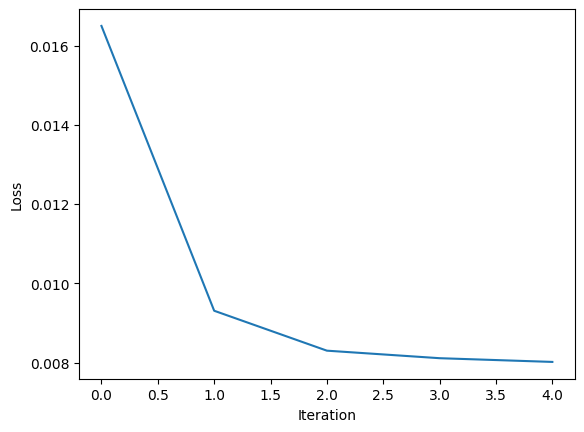

In [92]:
print(losses)
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Наши центроиды – цвета в пространстве RGB. Можно их нарисовать

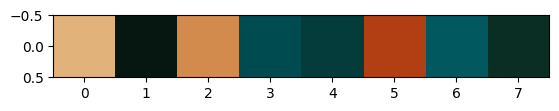

In [93]:
plt.imshow([centroids])

Теперь сделайте из `X` матрицу `Y`, в которой координаты каждой точки заменены на координаты центроида

In [94]:
Y = replace_points_with_centroids(centroids, y_pred)

In [95]:
Y

array([[0.02110015, 0.09040926, 0.06447663],
       [0.02110015, 0.09040926, 0.06447663],
       [0.02110015, 0.09040926, 0.06447663],
       ...,
       [0.04174777, 0.18376443, 0.1387407 ],
       [0.04174777, 0.18376443, 0.1387407 ],
       [0.04174777, 0.18376443, 0.1387407 ]], dtype=float32)

Посмотрим, что получилось

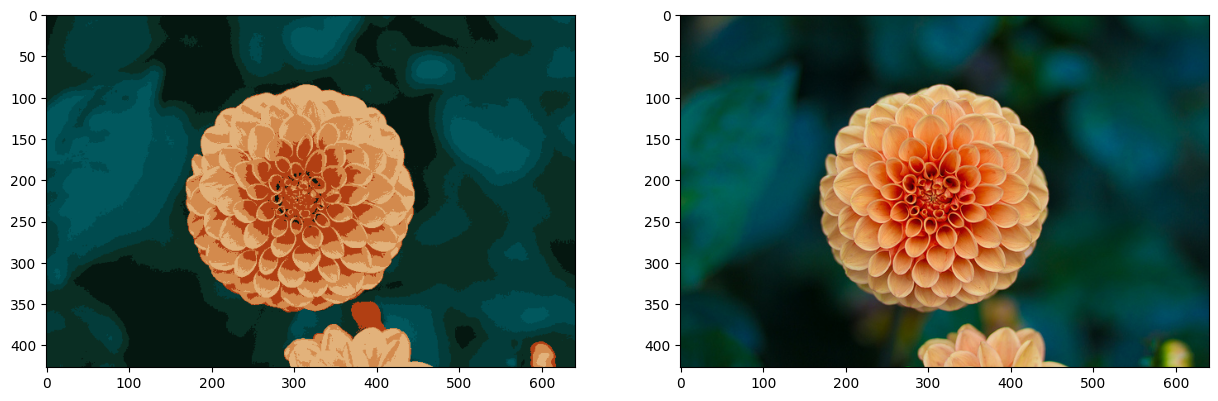

In [96]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

Поэкспериментируйте с разным числом кластеров

execution time(sec): 0.6190023
memory usage(kB): 25622.1103515625


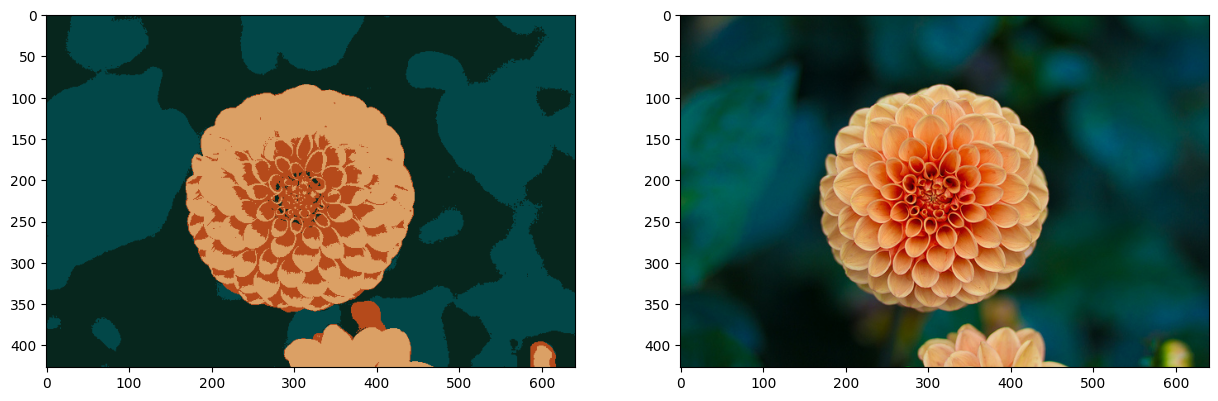

In [97]:
_ = interact_k_means(k=4, accuracy=1e-3)

execution time(sec): 0.6747647
memory usage(kB): 25622.2041015625


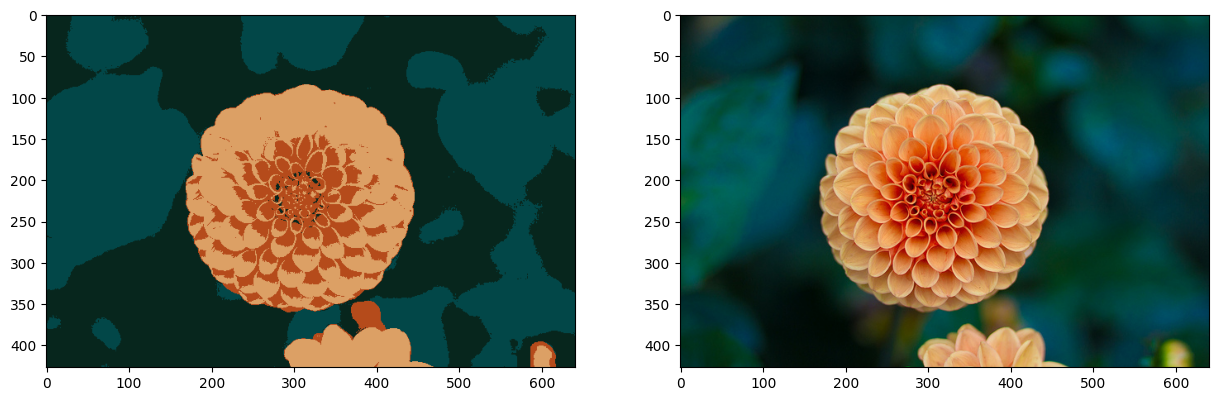

In [98]:
_ = interact_k_means(k=4, accuracy=1e-4)

execution time(sec): 0.1926501
memory usage(kB): 17081.8056640625


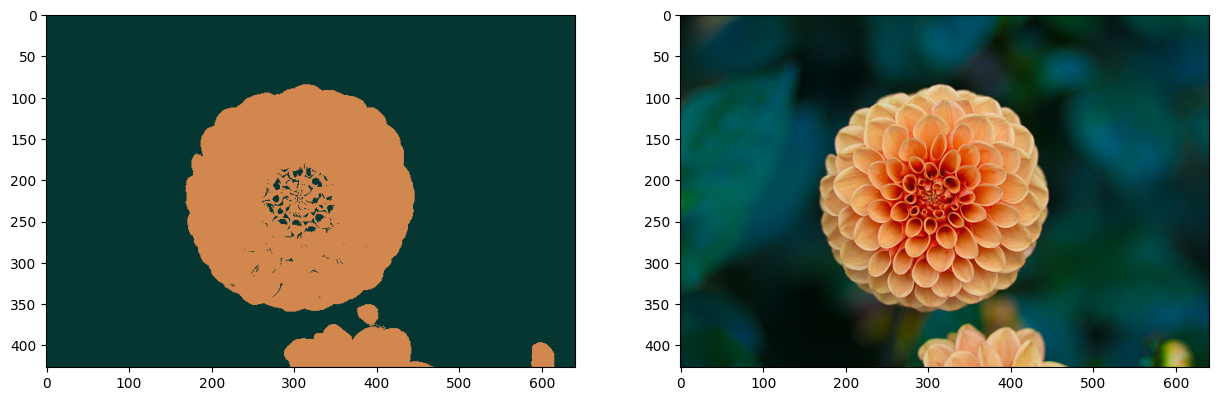

In [99]:
_ = interact_k_means(k=2)

execution time(sec): 7.6880299
memory usage(kB): 76866.5830078125


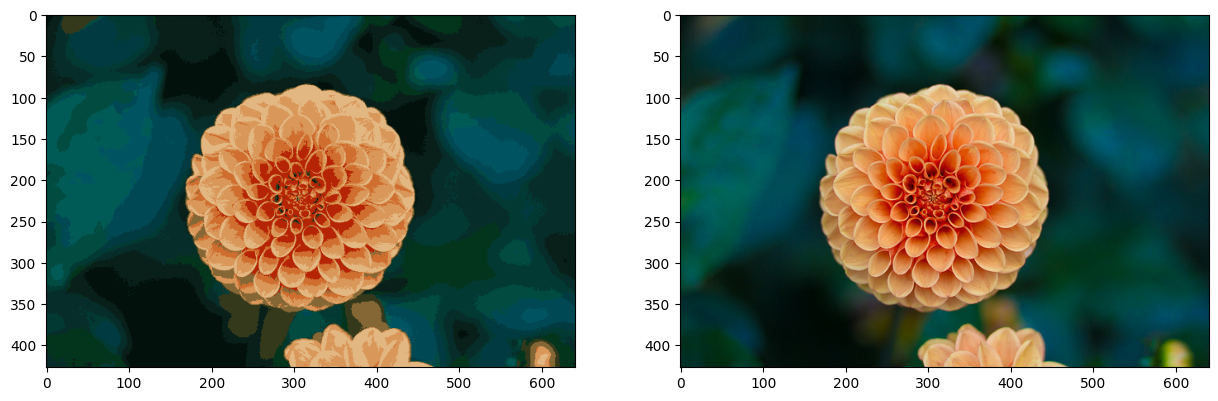

In [100]:
_ = interact_k_means(k=16)

execution time(sec): 22.4979045
memory usage(kB): 281827.8603515625


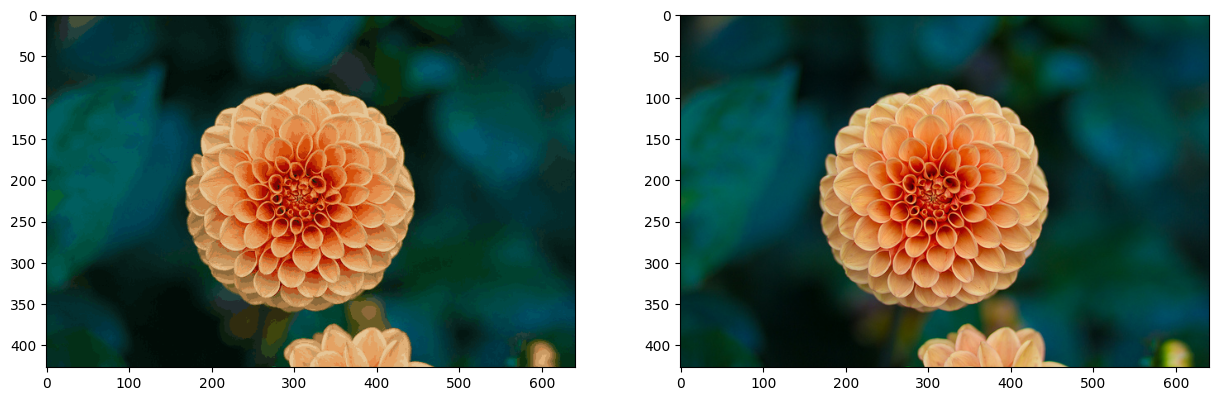

In [101]:
_ = interact_k_means(k=64)

### 2. Иерархическая кластеризация (1 балл)

Реализуйте алгоритм иерархической кластеризации

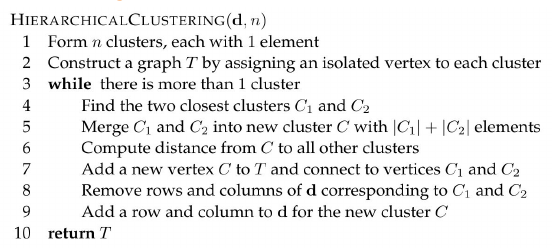

Для вычисления расстояний между кластерами используйте среднее расстояние между входящими в них точками:

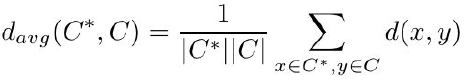



#### 2.1. Реализуйте функцию `distance_matrix`, вычисляющую матрицу попарных расстояний между точками. 
В качестве метрики мы будем использовать евклидово расстояние,

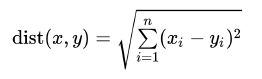


In [102]:
def distance_matrix(vector):
    """
    Compute matrix of pair-wise distances between samples
    :param vector: array-like of shape (n_samples, n_features)
        Samples
    :return D: array-like of shape (n_samples, n_samples)
        Matrix of pair-wise distances between samples
    """
    return distance.cdist(vector, vector, 'euclidean')

#### 2.2. Реализуйте функцию `linkage`. 

На вход подается матрица расстояний. На выходе – результат кластеризации в виде матрицы связей. Строки этой матрицы соответствуют операции объединения кластеров. Каждая строка имеет вид

```[C1, C2, dist(C1, C2), N]```

где `C1` и `C2` – номера объединяемых кластеров, `dist(C1, C2)` – расстояние между объединяемыми кластерами, `N` – число точек в новом кластере

Например, кластеризации

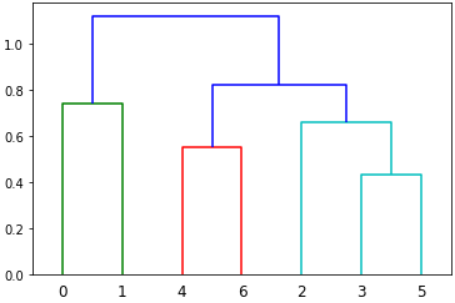

соответствует 
```
Z = [[ 3.    5.    0.43  2.  ]
     [ 4.    6.    0.55  2.  ]
     [ 2.    7.    0.66  3.  ]
     [ 0.    1.    0.74  2.  ]
     [ 8.    9.    0.82  5.  ]
     [10.   11.    1.12  7.  ]]
```


In [103]:
from typing import Any

class ClusterTableEntry:
    def __init__(self, cluster_id, index, size):
        self.cluster_id = cluster_id
        self.index = index
        self.size = size
        
        
def linkage(dist_matrix):
    """
    :param dist_matrix: array-like of shape (n_samples, n_samples)
            Matrix of pair-wise distances between samples
    :return linkage: Linkage matrix
    """
    dist_matrix_cpy = dist_matrix.copy()
    linkage_entries = []
    clusters = [ClusterTableEntry(i, i, 1) for i in range(len(dist_matrix))]
    first_availiable_id = len(dist_matrix)

    while len(clusters) > 1:
        row, col = min_index_except_diag(dist_matrix_cpy)
        entry_by_row = clusters[row]
        entry_by_col = clusters[col]
        entry_by_row.index = row
        entry_by_col.index = col

        new_entry, new_cluster_dist = merge_clusters(dist_matrix_cpy, entry_by_row, entry_by_col,
                                                     first_availiable_id, len(dist_matrix_cpy) - 1)
        first_availiable_id += 1
        next_dist_matrix = calc_next_distance_matrix(dist_matrix_cpy, new_cluster_dist, row, col)

        linkage_entries.append(
            [entry_by_row.cluster_id, entry_by_col.cluster_id, dist_matrix_cpy[row, col], new_entry.size])
        clusters = np.concatenate([np.delete(clusters, [row, col], axis=0), [new_entry]], axis=0)
        dist_matrix_cpy = next_dist_matrix

    return np.array(linkage_entries)


def min_index_except_diag(matrix):
    upper_triangle_indices = np.triu_indices(len(matrix), k=1)
    min_val_index = np.argmin(matrix[upper_triangle_indices])
    return upper_triangle_indices[0][min_val_index], upper_triangle_indices[1][min_val_index]


def merge_clusters(matrix, entry1: ClusterTableEntry, entry2: ClusterTableEntry, new_id: int,
                   idx: int) -> tuple[ClusterTableEntry, list[Any]]:
    return ClusterTableEntry(new_id, idx, entry1.size + entry2.size), recalc_dist_for_merged(entry1, entry2, matrix)


def recalc_dist_for_merged(entry1: ClusterTableEntry, entry2: ClusterTableEntry, matrix):
    # (distAC * (len(a) * len(c)) + distBC * (len(b) * len(c))) / ((len(a) + len(b)) * len(c)) =
    # (distAC * len(a) + distBC * len(b)) * len(c) / (len(c) * (len(a) + len(b))) =
    # (distAC * len(a) + distBC * len(b))  / (len(a) + len(b))
    return [
        (matrix[i][entry1.index] * entry1.size + matrix[i][entry2.index] * entry2.size) / (entry1.size + entry2.size)
        for i in range(len(matrix))]


def calc_next_distance_matrix(cur_distances, new_cluster_dist, min_row, min_col):
    next_dist_matrix = [[0 for _ in range(len(cur_distances) + 1)]]
    for i in range(len(cur_distances)):
        next_dist_matrix = np.concatenate([next_dist_matrix, [np.append(cur_distances[i], new_cluster_dist[i])]],
                                          axis=0)

    new_cluster_dist = np.append(new_cluster_dist, 0)
    next_dist_matrix = np.delete(next_dist_matrix, [0], axis=0)
    return np.delete(
        np.delete(np.concatenate([next_dist_matrix, [new_cluster_dist]], axis=0), [min_row, min_col], axis=0),
        [min_row, min_col], axis=1)


####  Проверка 1

In [104]:
# Нам дана матрица расстояний
D = np.array([[0.  , 0.74, 0.85, 0.54, 0.83, 0.92, 0.89],
              [0.74, 0.  , 1.59, 1.35, 1.2 , 1.48, 1.55],
              [0.85, 1.59, 0.  , 0.63, 1.13, 0.69, 0.73],
              [0.54, 1.35, 0.63, 0.  , 0.66, 0.43, 0.88],
              [0.83, 1.2 , 1.13, 0.66, 0.  , 0.72, 0.55],
              [0.92, 1.48, 0.69, 0.43, 0.72, 0.  , 0.8 ],
              [0.89, 1.55, 0.73, 0.88, 0.55, 0.8 , 0.  ]])

# кластеризуем
Z = linkage(D)
print(Z)
# и напечатаем что получилось
print(np.array(Z))

[[ 3.    5.    0.43  2.  ]
 [ 4.    6.    0.55  2.  ]
 [ 2.    7.    0.66  3.  ]
 [ 0.    1.    0.74  2.  ]
 [ 8.    9.    0.82  5.  ]
 [10.   11.    1.12  7.  ]]
[[ 3.    5.    0.43  2.  ]
 [ 4.    6.    0.55  2.  ]
 [ 2.    7.    0.66  3.  ]
 [ 0.    1.    0.74  2.  ]
 [ 8.    9.    0.82  5.  ]
 [10.   11.    1.12  7.  ]]


[[ 3.    5.    0.43  2.  ]
 [ 4.    6.    0.55  2.  ]
 [ 2.    7.    0.66  3.  ]
 [ 0.    1.    0.74  2.  ]
 [ 8.    9.    0.82  5.  ]
 [10.   11.    1.12  7.  ]]


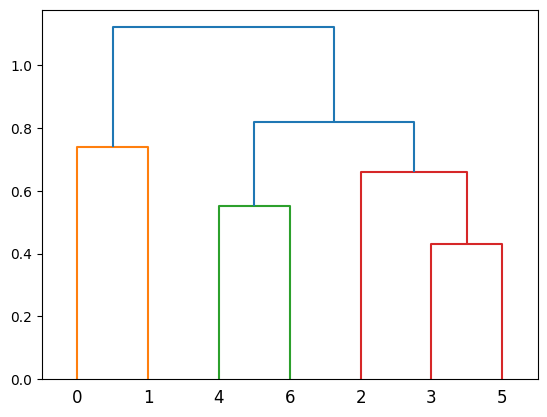

In [105]:
# для построения дендрограммы воспользуемся функцией из библиотеки scipy
from scipy.cluster.hierarchy import dendrogram

print(Z)
# должна получиться картинка из начала этого раздела
_ = dendrogram(Z)

####  Проверка 2

In [106]:
D = np.array([
    [0.  , 0.43, 0.93, 0.85, 0.94, 0.7 , 0.95, 0.79, 0.89, 1.34, 0.8 , 0.64, 1.42, 1.37, 0.86, 1.2 , 0.49, 0.19, 1.48, 0.86],
    [0.43, 0.  , 0.66, 0.7 , 1.48, 0.58, 0.7 , 0.55, 0.68, 1.45, 1.31, 0.37, 1.24, 1.69, 0.91, 1.28, 1.04, 0.29, 0.94, 1.05],
    [0.93, 0.66, 0.  , 1.01, 1.42, 0.8 , 0.76, 1.18, 0.21, 1.18, 1.35, 0.82, 0.68, 0.85, 0.75, 1.01, 0.93, 1.03, 0.6 , 0.91],
    [0.85, 0.7 , 1.01, 0.  , 1.02, 0.22, 0.89, 0.91, 0.79, 1.47, 1.04, 1.51, 0.71, 1.63, 0.34, 1.05, 1.24, 0.56, 1.09, 1.25],
    [0.94, 1.48, 1.42, 1.02, 0.  , 1.46, 1.48, 0.95, 1.44, 1.08, 0.3 , 1.29, 1.28, 0.65, 1.  , 0.8 , 0.8 , 0.92, 1.48, 0.65],
    [0.7 , 0.58, 0.8 , 0.22, 1.46, 0.  , 0.77, 1.  , 0.65, 1.25, 1.27, 1.36, 0.81, 1.56, 0.37, 0.98, 1.17, 0.68, 0.88, 1.23],
    [0.95, 0.7 , 0.76, 0.89, 1.48, 0.77, 0.  , 1.41, 1.08, 1.61, 1.65, 0.89, 0.76, 1.32, 0.64, 0.7 , 0.59, 1.07, 0.49, 0.91],
    [0.79, 0.55, 1.18, 0.91, 0.95, 1.  , 1.41, 0.  , 1.05, 0.73, 1.08, 0.7 , 1.49, 1.17, 1.  , 1.34, 1.45, 0.49, 1.06, 1.3 ],
    [0.89, 0.68, 0.21, 0.79, 1.44, 0.65, 1.08, 1.05, 0.  , 0.96, 1.09, 0.94, 0.44, 1.06, 0.9 , 1.47, 1.2 , 0.79, 1.04, 1.39],
    [1.34, 1.45, 1.18, 1.47, 1.08, 1.25, 1.61, 0.73, 0.96, 0.  , 0.96, 1.1 , 1.05, 0.48, 1.36, 1.26, 1.38, 1.38, 1.03, 1.38],
    [0.8 , 1.31, 1.35, 1.04, 0.3 , 1.27, 1.65, 1.08, 1.09, 0.96, 0.  , 1.08, 1.09, 0.79, 1.4 , 1.03, 1.02, 0.78, 1.79, 0.86],
    [0.64, 0.37, 0.82, 1.51, 1.29, 1.36, 0.89, 0.7 , 0.94, 1.1 , 1.08, 0.  , 1.42, 1.2 , 1.61, 1.3 , 0.86, 0.68, 1.04, 0.83],
    [1.42, 1.24, 0.68, 0.71, 1.28, 0.81, 0.76, 1.49, 0.44, 1.05, 1.09, 1.42, 0.  , 0.99, 0.84, 1.2 , 1.21, 1.22, 0.97, 1.58],
    [1.37, 1.69, 0.85, 1.63, 0.65, 1.56, 1.32, 1.17, 1.06, 0.48, 0.79, 1.2 , 0.99, 0.  , 1.13, 0.61, 1.  , 1.6 , 0.81, 0.83],
    [0.86, 0.91, 0.75, 0.34, 1.  , 0.37, 0.64, 1.  , 0.9 , 1.36, 1.4 , 1.61, 0.84, 1.13, 0.  , 0.68, 0.89, 0.86, 0.65, 1.04],
    [1.2 , 1.28, 1.01, 1.05, 0.8 , 0.98, 0.7 , 1.34, 1.47, 1.26, 1.03, 1.3 , 1.2 , 0.61, 0.68, 0.  , 0.92, 1.47, 0.47, 0.42],
    [0.49, 1.04, 0.93, 1.24, 0.8 , 1.17, 0.59, 1.45, 1.2 , 1.38, 1.02, 0.86, 1.21, 1.  , 0.89, 0.92, 0.  , 0.9 , 1.18, 0.49],
    [0.19, 0.29, 1.03, 0.56, 0.92, 0.68, 1.07, 0.49, 0.79, 1.38, 0.78, 0.68, 1.22, 1.6 , 0.86, 1.47, 0.9 , 0.  , 1.56, 1.21],
    [1.48, 0.94, 0.6 , 1.09, 1.48, 0.88, 0.49, 1.06, 1.04, 1.03, 1.79, 1.04, 0.97, 0.81, 0.65, 0.47, 1.18, 1.56, 0.  , 0.84],
    [0.86, 1.05, 0.91, 1.25, 0.65, 1.23, 0.91, 1.3 , 1.39, 1.38, 0.86, 0.83, 1.58, 0.83, 1.04, 0.42, 0.49, 1.21, 0.84, 0.  ]])


Выведите Linkage матрицу и постройте дендрограмму

In [107]:
# your code here
cluster_info = linkage(D)
print(cluster_info)
# и напечатаем что получилось
print(np.array(cluster_info))

[[ 0.         17.          0.19        2.        ]
 [ 2.          8.          0.21        2.        ]
 [ 3.          5.          0.22        2.        ]
 [ 4.         10.          0.3         2.        ]
 [14.         22.          0.355       3.        ]
 [ 1.         20.          0.36        3.        ]
 [15.         19.          0.42        2.        ]
 [ 9.         13.          0.48        2.        ]
 [ 6.         18.          0.49        2.        ]
 [12.         21.          0.56        3.        ]
 [11.         25.          0.56333333  4.        ]
 [ 7.         30.          0.6325      5.        ]
 [16.         26.          0.705       3.        ]
 [28.         32.          0.78166667  5.        ]
 [24.         29.          0.80666667  6.        ]
 [23.         27.          0.87        4.        ]
 [31.         34.          0.995      11.        ]
 [33.         36.          1.05890909 16.        ]
 [35.         37.          1.184375   20.        ]]
[[ 0.         17.          0.1

[[ 0.         17.          0.19        2.        ]
 [ 2.          8.          0.21        2.        ]
 [ 3.          5.          0.22        2.        ]
 [ 4.         10.          0.3         2.        ]
 [14.         22.          0.355       3.        ]
 [ 1.         20.          0.36        3.        ]
 [15.         19.          0.42        2.        ]
 [ 9.         13.          0.48        2.        ]
 [ 6.         18.          0.49        2.        ]
 [12.         21.          0.56        3.        ]
 [11.         25.          0.56333333  4.        ]
 [ 7.         30.          0.6325      5.        ]
 [16.         26.          0.705       3.        ]
 [28.         32.          0.78166667  5.        ]
 [24.         29.          0.80666667  6.        ]
 [23.         27.          0.87        4.        ]
 [31.         34.          0.995      11.        ]
 [33.         36.          1.05890909 16.        ]
 [35.         37.          1.184375   20.        ]]


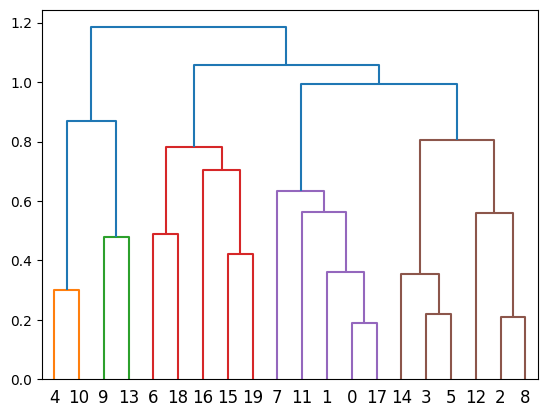

In [108]:
print(cluster_info)
# должна получиться картинка из начала этого раздела
_ = dendrogram(cluster_info)

#### 2.3. Digits dataset

In [109]:
from sklearn import datasets

# загрузим датасет Digits. Он состоит из рукописных изображений цифр
digits = datasets.load_digits().images

In [110]:
# выберем 20 случайных изображений
digits = np.random.permutation(digits)[:20]

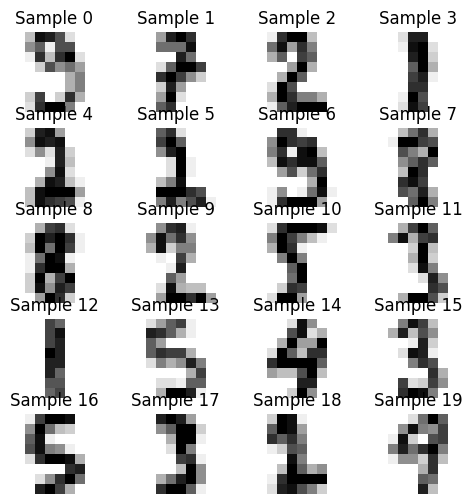

In [111]:
# вот они
_, axes = plt.subplots(nrows=5, ncols=4, figsize=(6, 6))
for i, (ax, image) in enumerate(zip(axes.flatten(), digits)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Sample {i}')

In [112]:
# каждое изображение – матрица размера (8, 8). Давайте вытянем ее в вектор признаков
XX = digits.reshape((digits.shape[0], -1))
XX

array([[ 0.,  4., 15., ...,  8.,  0.,  0.],
       [ 0.,  0.,  6., ...,  0.,  0.,  0.],
       [ 0.,  1., 13., ..., 16., 16.,  0.],
       ...,
       [ 0.,  0., 14., ..., 10.,  1.,  0.],
       [ 0.,  3., 16., ...,  8.,  3.,  0.],
       [ 0.,  0.,  0., ...,  4.,  0.,  0.]])

**Кластеризуйте вектора и постройте дендрограмму. Какие выводы можно из нее сделать?**

In [113]:
digits_dists = distance_matrix(XX)
digits_dists


array([[ 0.        , 50.5074252 , 43.30127019, 54.05552701, 46.13025038,
        52.22068556, 34.3220046 , 48.15599651, 48.23898838, 42.62628297,
        54.17564028, 38.13135193, 53.54437412, 41.54515616, 60.24948133,
        32.61901286, 50.32891813, 36.19392214, 49.86983056, 52.13444159],
       [50.5074252 ,  0.        , 45.97825573, 40.28647416, 49.54795657,
        54.31390246, 54.63515352, 41.27953488, 48.35286961, 47.68647607,
        48.90807704, 48.77499359, 43.22036557, 55.52476925, 58.23229345,
        45.90206967, 55.69560126, 48.91829923, 56.85068161, 54.12023651],
       [43.30127019, 45.97825573,  0.        , 48.91829923, 35.95830919,
        42.07136794, 49.18333051, 36.68787266, 41.27953488, 32.55764119,
        51.98076567, 45.5521679 , 50.51732376, 50.06995107, 66.55073253,
        41.09744518, 53.47896783, 46.67976007, 42.80186912, 62.71363488],
       [54.05552701, 40.28647416, 48.91829923,  0.        , 40.86563348,
        39.61060464, 62.3377895 , 37.53664876, 4

In [114]:
digits_cluster_info = linkage(digits_dists)
print(digits_cluster_info)
# и напечатаем что получилось
print(np.array(digits_cluster_info))

[[ 3.         12.         15.71623365  2.        ]
 [11.         15.         23.53720459  2.        ]
 [ 4.          5.         26.55183609  2.        ]
 [17.         21.         31.26356806  3.        ]
 [18.         22.         31.86886006  3.        ]
 [ 7.          8.         32.06243908  2.        ]
 [ 2.          9.         32.55764119  2.        ]
 [ 0.          6.         34.3220046   2.        ]
 [13.         16.         34.39476704  2.        ]
 [24.         26.         39.95879171  5.        ]
 [14.         19.         40.24922359  2.        ]
 [23.         27.         40.72486562  5.        ]
 [ 1.         20.         41.75341986  3.        ]
 [25.         29.         43.22922929  7.        ]
 [28.         31.         44.50627389  7.        ]
 [32.         33.         45.82781265 10.        ]
 [10.         35.         46.96118036 11.        ]
 [34.         36.         50.21042677 18.        ]
 [30.         37.         57.58673895 20.        ]]
[[ 3.         12.         15.7

[[ 3.         12.         15.71623365  2.        ]
 [11.         15.         23.53720459  2.        ]
 [ 4.          5.         26.55183609  2.        ]
 [17.         21.         31.26356806  3.        ]
 [18.         22.         31.86886006  3.        ]
 [ 7.          8.         32.06243908  2.        ]
 [ 2.          9.         32.55764119  2.        ]
 [ 0.          6.         34.3220046   2.        ]
 [13.         16.         34.39476704  2.        ]
 [24.         26.         39.95879171  5.        ]
 [14.         19.         40.24922359  2.        ]
 [23.         27.         40.72486562  5.        ]
 [ 1.         20.         41.75341986  3.        ]
 [25.         29.         43.22922929  7.        ]
 [28.         31.         44.50627389  7.        ]
 [32.         33.         45.82781265 10.        ]
 [10.         35.         46.96118036 11.        ]
 [34.         36.         50.21042677 18.        ]
 [30.         37.         57.58673895 20.        ]]


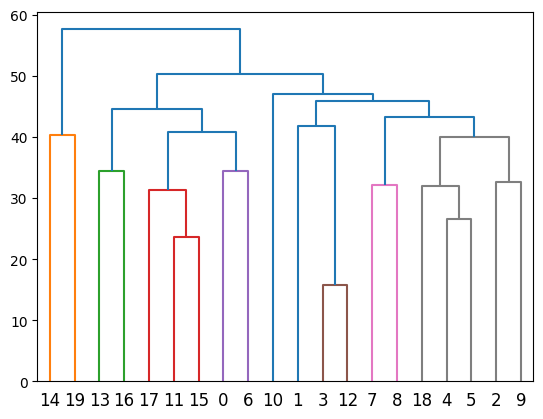

In [115]:
print(digits_cluster_info)
# должна получиться картинка из начала этого раздела
_ = dendrogram(digits_cluster_info)

Тут получились результаты не совсем такие, как в оригинальном блокноте, потому как перестановки картинок цифр, сгенерированные моим локальным рандомайзером и в исходном варианте, отличаются, но вроде как результаты соответствуют действительности

**Выводы:**


* По первому: вполне логичным образом при увеличении числа категорий возрастают затрачиваемые ресурсы(в целом и без замеров очевидно, но я прикрутила измерение времени и памяти на fit_predict)
* По второму: даже отличающиеся изображения одной и той же цифры будут определяться скорее как более схожие объекты, нежели остальные: например разные изображения цифры '1' почти наверное будут объединены в один кластер на каком-то из первых этапов, тогда как изображение '3' и '9' попадут в один кластер на каком-то из последних мержей дерева

*не знаю, какие выводы тут еще ожидались, если будут какие-то указания на более конкретные вещи, на счет которых стоит порассуждать, могу дописать сюда)*